<a href="https://colab.research.google.com/github/milkywayweaver/learn_pytorch/blob/main/course/PyT_C004_Multiclass_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics > /dev/null

**Multiclass Classification**

In [2]:
import torch
from torch import nn
import torchmetrics

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Define some functions

✅ Make functions <br>
plot_area() function is a modified copy of plot_decision_boundary() function by Daniel Bourke.

🌐 https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py

In [3]:
def plot_area(model,X,y,with_lim=True,opacity=0.3):
  # Put everything to CPU
  model.to('cpu')
  X, y =X.to('cpu'), y.to('cpu')

  # Create a meshgrid
  x_min, x_max = X[:,0].min()-0.1, X[:,0].max()+0.1
  y_min, y_max = X[:,1].min()-0.1, X[:,1].max()+0.1
  xx, yy = np.meshgrid(np.linspace(x_min,x_max,101),
                       np.linspace(y_min,y_max,101))
  X_grid = torch.tensor(np.c_[xx.ravel(),yy.ravel()],dtype=torch.float32)

  # Make grid predictions
  model.eval()
  with torch.inference_mode():
    y_logits = model(X_grid)
  if len(torch.unique(y)) > 2:
    y_preds = torch.argmax(torch.softmax(y_logits,1),1)
  else:
    y_preds = torch.round(torch.sigmoid(y_logits))

  # Plot the predcition area
  y_preds = torch.reshape(y_preds,xx.shape).detach().numpy()
  plt.contourf(xx,yy,y_preds,cmap='cool',alpha=opacity,zorder=0)
  if with_lim == True:
    plt.xlim(x_min,x_max)
    plt.ylim(y_min,y_max)

def accuracy(y_preds,y_test):
  return torch.eq(y_preds,y_test).sum().item()/len(y_preds)

# Creating the data

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

✅ Create the blob data

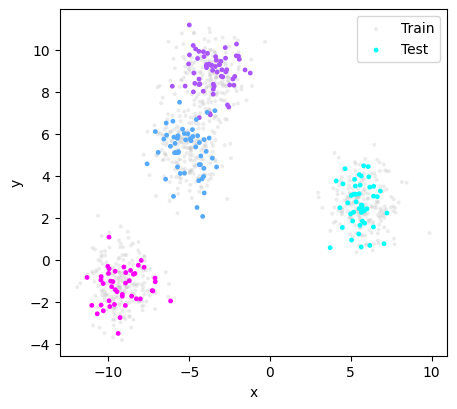

In [5]:
# Define blobs parameters
n_class = 4
n_features = 2
random_seed = 46

# Make the blobs
X, y = make_blobs(n_samples=1000,
                  n_features=n_features,
                  centers=n_class,
                  cluster_std=1.,
                  random_state=random_seed)

# Turn the blobs into tensors
X = torch.tensor(X,dtype=torch.float32,device=device)
y = torch.tensor(y,dtype=torch.long,device=device)
# Split train and test data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=46)

# Visualize the blobs
plt.figure(figsize=(5,4.5))
plt.scatter(X_train.cpu()[:,0],X_train.cpu()[:,1],c='silver',s=8,alpha=0.3,edgecolors='none',label='Train')
plt.scatter(X_test.cpu()[:,0],X_test.cpu()[:,1],c=y_test.cpu(),cmap='cool',s=6,alpha=1,zorder=1,label='Test')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# Creating and training the model

✅ Build the model

In [6]:
class MulticlassClassification(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    '''
    Args:
      input_features (int) : number of input features
      output_features (int) : number of the different classes
      hidden_units (int) : number of hidden units per layer
    '''
    super().__init__()
    self.nnlayers = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units,device=device),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units,device=device),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features,device=device)
    )

  def forward(self,x):
    return self.nnlayers(x)

✅ Build the train loop

In [7]:
torch_accuracy = torchmetrics.Accuracy(task='multiclass',num_classes=4).to(device)

def train(model,epochs,lr,show_progress=True):
  # Define the loss function and optimizer
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)

  epoch_counts = []
  losses = []
  test_losses = []
  accs = []
  test_accs = []

  # Build the training loop
  for epoch in range(epochs):
    epoch_counts.append(epoch)
    # Train
    model.train()
    y_logits = model(X_train)
    loss = loss_fn(y_logits,y_train)
    losses.append(loss.detach().item())
    y_preds = torch.softmax(y_logits,1)
    # acc = accuracy(y_preds.argmax(1),y_train)
    acc = torch_accuracy(y_preds.argmax(1),y_train)
    accs.append(acc.detach().item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluate
    model.eval()
    with torch.inference_mode():
      test_logits = model(X_test)
      test_loss = loss_fn(test_logits,y_test)
      test_losses.append(test_loss.detach().item())
      test_preds = torch.softmax(test_logits,1)
      # test_acc = accuracy(test_preds.argmax(1),y_test)
      test_acc = torch_accuracy(test_preds.argmax(1),y_test)
      test_accs.append(test_acc.detach().item())

    # Print training metrics
    if show_progress == True:
      if epoch % int(epochs/10) == 0:
        # print(f'Epoch: {epoch}\t| Loss: {loss:.3f}\t| Test Loss: {test_loss:.3f}')
        print(f'Epoch: {epoch}\t| Accuracy: {acc*100:.2f}%\t| Test Accuracy: {test_acc*100:.2f}%')

  return epoch_counts,losses,test_losses,accs,test_accs

✅ Train the model

In [8]:
model = MulticlassClassification(input_features=2,
                                 output_features=4,
                                 hidden_units=256)

In [9]:
epoch_counts,losses,test_losses,accs,test_accs = train(model,200,0.01)

Epoch: 0	| Accuracy: 23.88%	| Test Accuracy: 70.50%
Epoch: 20	| Accuracy: 96.88%	| Test Accuracy: 98.00%
Epoch: 40	| Accuracy: 97.62%	| Test Accuracy: 97.50%
Epoch: 60	| Accuracy: 97.62%	| Test Accuracy: 97.50%
Epoch: 80	| Accuracy: 97.62%	| Test Accuracy: 98.00%
Epoch: 100	| Accuracy: 97.62%	| Test Accuracy: 98.00%
Epoch: 120	| Accuracy: 97.88%	| Test Accuracy: 98.00%
Epoch: 140	| Accuracy: 97.88%	| Test Accuracy: 98.00%
Epoch: 160	| Accuracy: 97.75%	| Test Accuracy: 99.00%
Epoch: 180	| Accuracy: 97.88%	| Test Accuracy: 99.00%


# Evaluate the model

Accuracy: 98.5%


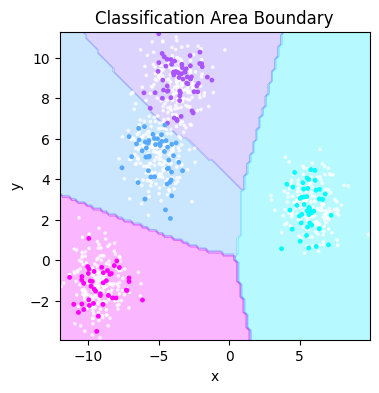

In [10]:
model.eval()
with torch.inference_mode():
  y_preds = torch.argmax(torch.softmax(model(X_test),1),1)

print(f'Accuracy: {torch.eq(y_preds,y_test).sum().item()/len(y_test)*100}%')

plt.figure(figsize=(4,4))
plot_area(model,X,y,opacity=0.3)
plt.scatter(X_train.cpu()[:,0],X_train.cpu()[:,1],c='white',s=7,alpha=0.8,edgecolors='none',zorder=1)
plt.scatter(X_test.cpu()[:,0],X_test.cpu()[:,1],c=y_preds.cpu(),cmap='cool',s=6,alpha=1,zorder=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Classification Area Boundary')
plt.show()

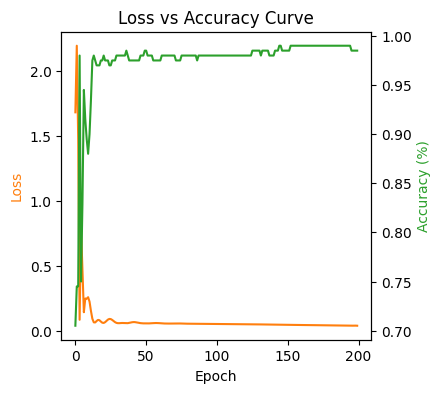

In [11]:
fig, ax = plt.subplots(figsize=(4,4))
ax1 = ax.twinx()
ax.plot(epoch_counts,test_losses,color='C1',label='Loss')
ax.set_ylabel('Loss',color='C1')

ax1.plot(epoch_counts,test_accs,color='C2',label='Accuracy')
ax1.set_ylabel('Accuracy (%)',color='C2')

ax.set_xlabel('Epoch')
ax.set_title('Loss vs Accuracy Curve')
plt.show()

# Noise in data vs accuracy

❗ **Accuracy would be lower as the noise in the data increases.**

In [12]:
metrics = []
noises = np.linspace(0.8,1.8,11)
for noise in noises:
  # Make the blobs
  X, y = make_blobs(n_samples=1000,
                    n_features=n_features,
                    centers=n_class,
                    cluster_std=noise,
                    random_state=random_seed)

  # Turn the blobs into tensors
  X = torch.tensor(X,dtype=torch.float32,device=device)
  y = torch.tensor(y,dtype=torch.long,device=device)
  # Split train and test data
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=46)

  # Initiate the model
  model = MulticlassClassification(input_features=2,
                                  output_features=4,
                                  hidden_units=256)

  # Train the model
  metric = train(model,100,0.01,show_progress=False)
  metrics.append(metric)

metrics = np.array(metrics)

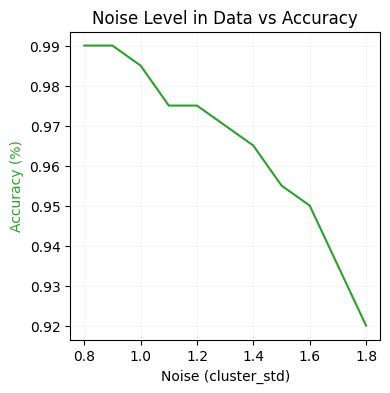

In [13]:
plt.figure(figsize=(4,4))
plt.plot(noises, metrics[:,4,-1],color='C2',zorder=2)
plt.xlabel('Noise (cluster_std)')
plt.ylabel('Accuracy (%)',color='C2')
plt.title('Noise Level in Data vs Accuracy')
plt.grid(zorder=0,color='whitesmoke')
plt.show()